In [2]:
import json
import os
import time
import pandas as pd
import numpy as np
import csv


import utils
import eval_util
import losses
import frame_level_models
import video_level_models
import readers
import tensorflow as tf
from tensorflow import app
from tensorflow import flags
from tensorflow import gfile
from tensorflow import logging

flags = tf.app.flags
FLAGS = flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
location = "jungle"
#location = "urban"

In [4]:
train_dir = "models/models_" + location
eval_data_pattern = "tfrecords/eval_"  + location + "_new/*.tfrecord"
label_filename = "csv_files/class_labels_indices_" + location + ".csv"
score_filename = "csv_files/class_labels_indices_" + location + "_score.csv"

num_classes = 16
#if(location=="jungle"):
#    num_classes = 15

In [5]:
# Dataset flags.
flags.DEFINE_string("feature_names", "audio_embedding", "Name of the feature "
                  "to use for training.")
flags.DEFINE_string("feature_sizes", "128", "Length of the feature vectors.")

In [6]:
# Model flags
flags.DEFINE_bool(
  "frame_features", True,
  "If set, then --eval_data_pattern must be frame-level features. "
  "Otherwise, --eval_data_pattern must be aggregated video-level "
  "features. The model must also be set appropriately (i.e. to read 3D "
  "batches VS 4D batches.")
flags.DEFINE_string(
  "model", "FrameLevelLogisticModel",
  "Which architecture to use for the model. Options include 'Logistic', "
  "'SingleMixtureMoe', and 'TwoLayerSigmoid'. See aggregated_models.py and "
  "frame_level_models.py for the model definitions.")
flags.DEFINE_integer("batch_size", 512,
                   "How many examples to process per batch.")
flags.DEFINE_string("label_loss", "CrossEntropyLoss",
                  "Loss computed on validation data")

In [7]:
# Other flags.
flags.DEFINE_integer("num_readers", 8,
                   "How many threads to use for reading input files.")
flags.DEFINE_boolean("run_once", True, "Whether to run eval only once.")
flags.DEFINE_integer("top_k", 10, "How many predictions to output per video.")

In [8]:
# HK  get ground truth
ground_thruth = eval_util.get_labels(label_filename)
gt_labels = [ground_thruth[k] for k in ground_thruth]

In [9]:
if(location=="jungle" and "Gunshot SC9mm" in gt_labels):
    gt_labels.remove("Gunshot SC9mm")
gt_labels

['Car, boat, motorcyle, truck',
 'Chainsaw',
 'Chop',
 'Gunshot, gunfire',
 'Helicopter',
 'Male singing',
 'Cattle',
 'Radio',
 'Shout',
 'Silence',
 'Wind noise (microphone)',
 'Gunshot SC556',
 'Elephant_Wenger',
 'Bush_Wenger',
 'Elephant_Angela',
 'Background_Angela']

In [10]:
logging.set_verbosity(tf.logging.INFO)
print("tensorflow version: %s" % tf.__version__)

tensorflow version: 1.8.0


In [11]:
def get_input_evaluation_tensors(reader,
                                 data_pattern,
                                 batch_size=1024,
                                 num_readers=1):
  """Creates the section of the graph which reads the evaluation data.

  Args:
    reader: A class which parses the training data.
    data_pattern: A 'glob' style path to the data files.
    batch_size: How many examples to process at a time.
    num_readers: How many I/O threads to use.

  Returns:
    A tuple containing the features tensor, labels tensor, and optionally a
    tensor containing the number of frames per video. The exact dimensions
    depend on the reader being used.

  Raises:
    IOError: If no files matching the given pattern were found.
  """
  logging.info("Using batch size of " + str(batch_size) + " for evaluation.")
  with tf.name_scope("eval_input"):
    files = gfile.Glob(data_pattern)
    if not files:
      raise IOError("Unable to find the evaluation files.")
    logging.info("number of evaluation files: " + str(len(files)))
    filename_queue = tf.train.string_input_producer(
        files, shuffle=False, num_epochs=1)
    eval_data = [
        reader.prepare_reader(filename_queue) for _ in range(num_readers)
    ]
    return tf.train.batch_join(
        eval_data,
        batch_size=batch_size,
        capacity=3 * batch_size,
        allow_smaller_final_batch=True,
        enqueue_many=True)

In [12]:
def find_class_by_name(name, modules):
  """Searches the provided modules for the named class and returns it."""
  modules = [getattr(module, name, None) for module in modules]
  return next(a for a in modules if a)

In [13]:
def build_graph(reader,
                model,
                eval_data_pattern,
                label_loss_fn,
                batch_size=1024,
                num_readers=1):
  """Creates the Tensorflow graph for evaluation.

  Args:
    reader: The data file reader. It should inherit from BaseReader.
    model: The core model (e.g. logistic or neural net). It should inherit
           from BaseModel.
    eval_data_pattern: glob path to the evaluation data files.
    label_loss_fn: What kind of loss to apply to the model. It should inherit
                from BaseLoss.
    batch_size: How many examples to process at a time.
    num_readers: How many threads to use for I/O operations.
  """

  global_step = tf.Variable(0, trainable=False, name="global_step")
  video_id_batch, model_input_raw, labels_batch, num_frames = get_input_evaluation_tensors(  # pylint: disable=g-line-too-long
      reader,
      eval_data_pattern,
      batch_size=batch_size,
      num_readers=num_readers)
  tf.summary.histogram("model_input_raw", model_input_raw)
  
  feature_dim = len(model_input_raw.get_shape()) - 1

  # Normalize input features.
  model_input = tf.nn.l2_normalize(model_input_raw, feature_dim)

  with tf.variable_scope("tower"):
    result = model.create_model(model_input,
                                num_frames=num_frames,
                                vocab_size=reader.num_classes,
                                labels=labels_batch,
                                is_training=False)
    predictions = result["predictions"]
    tf.summary.histogram("model_activations", predictions)
    if "loss" in result.keys():
      label_loss = result["loss"]
    else:
      label_loss = label_loss_fn.calculate_loss(predictions, labels_batch)

  tf.add_to_collection("global_step", global_step)
  tf.add_to_collection("loss", label_loss)
  tf.add_to_collection("predictions", predictions)
  tf.add_to_collection("input_batch", model_input)
  tf.add_to_collection("video_id_batch", video_id_batch)
  tf.add_to_collection("num_frames", num_frames)
  tf.add_to_collection("labels", tf.cast(labels_batch, tf.float32))
  tf.add_to_collection("summary_op", tf.summary.merge_all())

In [14]:
def evaluation_loop(video_id_batch, prediction_batch, label_batch, loss,
                    summary_op, saver, summary_writer, evl_metrics,
                    last_global_step_val):
  """Run the evaluation loop once.

  Args:
    video_id_batch: a tensor of video ids mini-batch.
    prediction_batch: a tensor of predictions mini-batch.
    label_batch: a tensor of label_batch mini-batch.
    loss: a tensor of loss for the examples in the mini-batch.
    summary_op: a tensor which runs the tensorboard summary operations.
    saver: a tensorflow saver to restore the model.
    summary_writer: a tensorflow summary_writer
    evl_metrics: an EvaluationMetrics object.
    last_global_step_val: the global step used in the previous evaluation.

  Returns:
    The global_step used in the latest model.
  """

  global_step_val = -1
  with tf.Session() as sess:
    latest_checkpoint = tf.train.latest_checkpoint(train_dir)
    if latest_checkpoint:
      logging.info("Loading checkpoint for eval: " + latest_checkpoint)
      # Restores from checkpoint
      saver.restore(sess, latest_checkpoint)
      # Assuming model_checkpoint_path looks something like:
      # /my-favorite-path/yt8m_train/model.ckpt-0, extract global_step from it.
      global_step_val = latest_checkpoint.split("/")[-1].split("-")[-1]
    else:
      logging.info("No checkpoint file found.")
      return global_step_val

    if global_step_val == last_global_step_val:
      logging.info("skip this checkpoint global_step_val=%s "
                   "(same as the previous one).", global_step_val)
      return global_step_val

    sess.run([tf.local_variables_initializer()])

    # Start the queue runners.
    fetches = [video_id_batch, prediction_batch, label_batch, loss, summary_op]
    coord = tf.train.Coordinator()
    try:
      threads = []
      for qr in tf.get_collection(tf.GraphKeys.QUEUE_RUNNERS):
        threads.extend(qr.create_threads(
            sess, coord=coord, daemon=True,
            start=True))
      logging.info("enter eval_once loop global_step_val = %s. ",
                   global_step_val)

      evl_metrics.clear()

      examples_processed = 0
      while not coord.should_stop():
        batch_start_time = time.time()
        _, predictions_val, labels_val, loss_val, summary_val = sess.run(
            fetches)

        seconds_per_batch = time.time() - batch_start_time
        example_per_second = labels_val.shape[0] / seconds_per_batch
        examples_processed += labels_val.shape[0]
        
        iteration_info_dict = evl_metrics.accumulate(predictions_val,
                                                     labels_val, loss_val, gt_labels)
        iteration_info_dict["examples_per_second"] = example_per_second

        iterinfo = utils.AddGlobalStepSummary(
            summary_writer,
            global_step_val,
            iteration_info_dict,
            summary_scope="Eval")
        logging.info("examples_processed: %d | %s", examples_processed,
                     iterinfo)

      print("predictions_val: ")
      print(predictions_val)
      print("labels_val: ")
      print(labels_val)
      print("loss val: ")
      print(loss_val)
    
    except tf.errors.OutOfRangeError as e:
      logging.info(
          "Done with batched inference. Now calculating global performance "
          "metrics.")
      # calculate the metrics for the entire epoch
      epoch_info_dict = evl_metrics.get()
      epoch_info_dict["epoch_id"] = global_step_val

      print("gt_labels: " + str(gt_labels))
      summary_writer.add_summary(summary_val, global_step_val)
      epochinfo = utils.AddEpochSummary(
          summary_writer,
          global_step_val,
          epoch_info_dict,
          gt_labels,
          summary_scope="Eval",
          csv_file = score_filename)
      logging.info(epochinfo)
      evl_metrics.store()
    
      evl_metrics.clear()
    except Exception as e:  # pylint: disable=broad-except
      logging.info("Unexpected exception: " + str(e))
      coord.request_stop(e)

    coord.request_stop()
    coord.join(threads, stop_grace_period_secs=10)

    return global_step_val

In [15]:
tf.set_random_seed(0)  # for reproducibility
with tf.Graph().as_default():
    # convert feature_names and feature_sizes to lists of values
    feature_names, feature_sizes = utils.GetListOfFeatureNamesAndSizes(
        FLAGS.feature_names, FLAGS.feature_sizes)

    if FLAGS.frame_features:
      reader = readers.YT8MFrameFeatureReader(
          num_classes=num_classes,
          feature_names=feature_names,feature_sizes=feature_sizes)
    else:
      reader = readers.YT8MAggregatedFeatureReader(
          num_classes=num_classes,
          feature_names=feature_names, feature_sizes=feature_sizes)

    model = find_class_by_name(FLAGS.model,
        [frame_level_models, video_level_models])()
    label_loss_fn = find_class_by_name(FLAGS.label_loss, [losses])()

    if eval_data_pattern is "":
        raise IOError("'eval_data_pattern' was not specified. " +
                     "Nothing to evaluate.")

    build_graph(
        reader=reader,
        model=model,
        eval_data_pattern=eval_data_pattern,
        label_loss_fn=label_loss_fn,
        num_readers=FLAGS.num_readers,
        batch_size=FLAGS.batch_size)
    logging.info("built evaluation graph")
    video_id_batch = tf.get_collection("video_id_batch")[0]
    prediction_batch = tf.get_collection("predictions")[0]
    label_batch = tf.get_collection("labels")[0]
    loss = tf.get_collection("loss")[0]
    summary_op = tf.get_collection("summary_op")[0]

    saver = tf.train.Saver(tf.global_variables())
    summary_writer = tf.summary.FileWriter(
        train_dir, graph=tf.get_default_graph())

    evl_metrics = eval_util.EvaluationMetrics(reader.num_classes, FLAGS.top_k)

    last_global_step_val = -1
    while True:
      last_global_step_val = evaluation_loop(video_id_batch, prediction_batch,
                                             label_batch, loss, summary_op,
                                             saver, summary_writer, evl_metrics,
                                             last_global_step_val)
      if FLAGS.run_once:
        break

INFO:tensorflow:Using batch size of 512 for evaluation.
INFO:tensorflow:number of evaluation files: 2148
INFO:tensorflow:built evaluation graph
INFO:tensorflow:Loading checkpoint for eval: models/models_jungle\model.ckpt-3510
INFO:tensorflow:Restoring parameters from models/models_jungle\model.ckpt-3510
INFO:tensorflow:enter eval_once loop global_step_val = 3510. 
INFO:tensorflow:examples_processed: 512 | global_step 3510 | Batch Hit@1: 0.508 | Batch PERR: 0.508 | Batch Loss: 3.460 | Examples_per_sec: 262.845
INFO:tensorflow:examples_processed: 1024 | global_step 3510 | Batch Hit@1: 0.643 | Batch PERR: 0.643 | Batch Loss: 3.266 | Examples_per_sec: 872.641
INFO:tensorflow:examples_processed: 1536 | global_step 3510 | Batch Hit@1: 0.697 | Batch PERR: 0.696 | Batch Loss: 3.152 | Examples_per_sec: 875.411
INFO:tensorflow:examples_processed: 2048 | global_step 3510 | Batch Hit@1: 0.729 | Batch PERR: 0.729 | Batch Loss: 2.400 | Examples_per_sec: 848.994
INFO:tensorflow:examples_processed: 25

In [16]:
## Plot evaluation results:
df = pd.read_csv(score_filename, sep=";")
df.sort_values(by=['aps'], ascending=False)

dff = df.query('aps > 0.1')
dff = dff.sort_values(by=['aps'], ascending=False)

df

,label,aps
0,"Car, boat, motorcyle, truck",0.764451
1,Chainsaw,0.884480
2,Chop,0.467318
3,"Gunshot, gunfire",0.751317
4,Helicopter,0.804897
5,Male singing,0.835291
6,Cattle,0.647598
7,Radio,0.834352
8,Shout,0.818116
9,Silence,0.729550


In [17]:
# load the saved data
from numpy import genfromtxt
p = genfromtxt('csv_files/predictions.csv', delimiter=',')
l = genfromtxt('csv_files/labels.csv', delimiter=',')

In [18]:
p.shape

(9952, 16)

In [19]:
## Deze code alleen runnen als je labels wilt samenvoegen
## (bus, car, motorcycle, truck)
## (firecracker, fireworks)
if(location=="urban"):
    l[:,1] = l[:,[1,2,7,13]].max(axis=1)
    l[:,4] = l[:,[4,5]].max(axis=1)
    l = l[:,[0,1,3,4,6,8,9,10,11,12,14,15]]

    p[:,1] = p[:,[1,2,7,13]].max(axis=1)
    p[:,4] = p[:,[4,5]].max(axis=1)
    p = p[:,[0,1,3,4,6,8,9,10,11,12,14,15]]
    
    gt_labels = [gt_labels[i] for i in [0,1,3,5,6,8,9,10,11,12,14,15]]
    gt_labels[1] = 'Bus, car, motorcycle, truck'
elif(location=="jungle"):
    l = l[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15]]
    p = p[:,[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15]]

In [20]:
# Remove Angela-bush
p.shape

(9952, 15)

In [86]:
from sklearn.metrics import confusion_matrix
import numpy as np

p.shape[1]

def buildCM(p,l, cutoff=0.3) :
    # check if square
    if p.shape[1] != l.shape[1] :
        return
    cm = np.zeros((p.shape[1],l.shape[1]))
    # now fill
    for r in range(p.shape[0]):
        # for every example
        for i in range(p.shape[1]):
            # for every prediction
            for j in range(l.shape[1]):
                # check every combination
                if l[r][j] == 1.0 and p[r][i] > cutoff :
                    cm[i,j] += 1

    return cm

cm = buildCM(p,l, 0.5)

In [87]:
## CM: colors in proportion to nr occurences labels
occur_labels = pd.read_csv('csv_files/nr_occur_labels.csv')
occur_labels = occur_labels.iloc[[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15],:]

In [88]:
occurences = occur_labels.iloc[:,1]

In [89]:
for i in range(cm.shape[0]):
    cm[:,i] = round(100*(cm[:,i]/occurences),1)

In [90]:
%matplotlib inline

from textwrap import wrap
import re
import itertools
import matplotlib

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


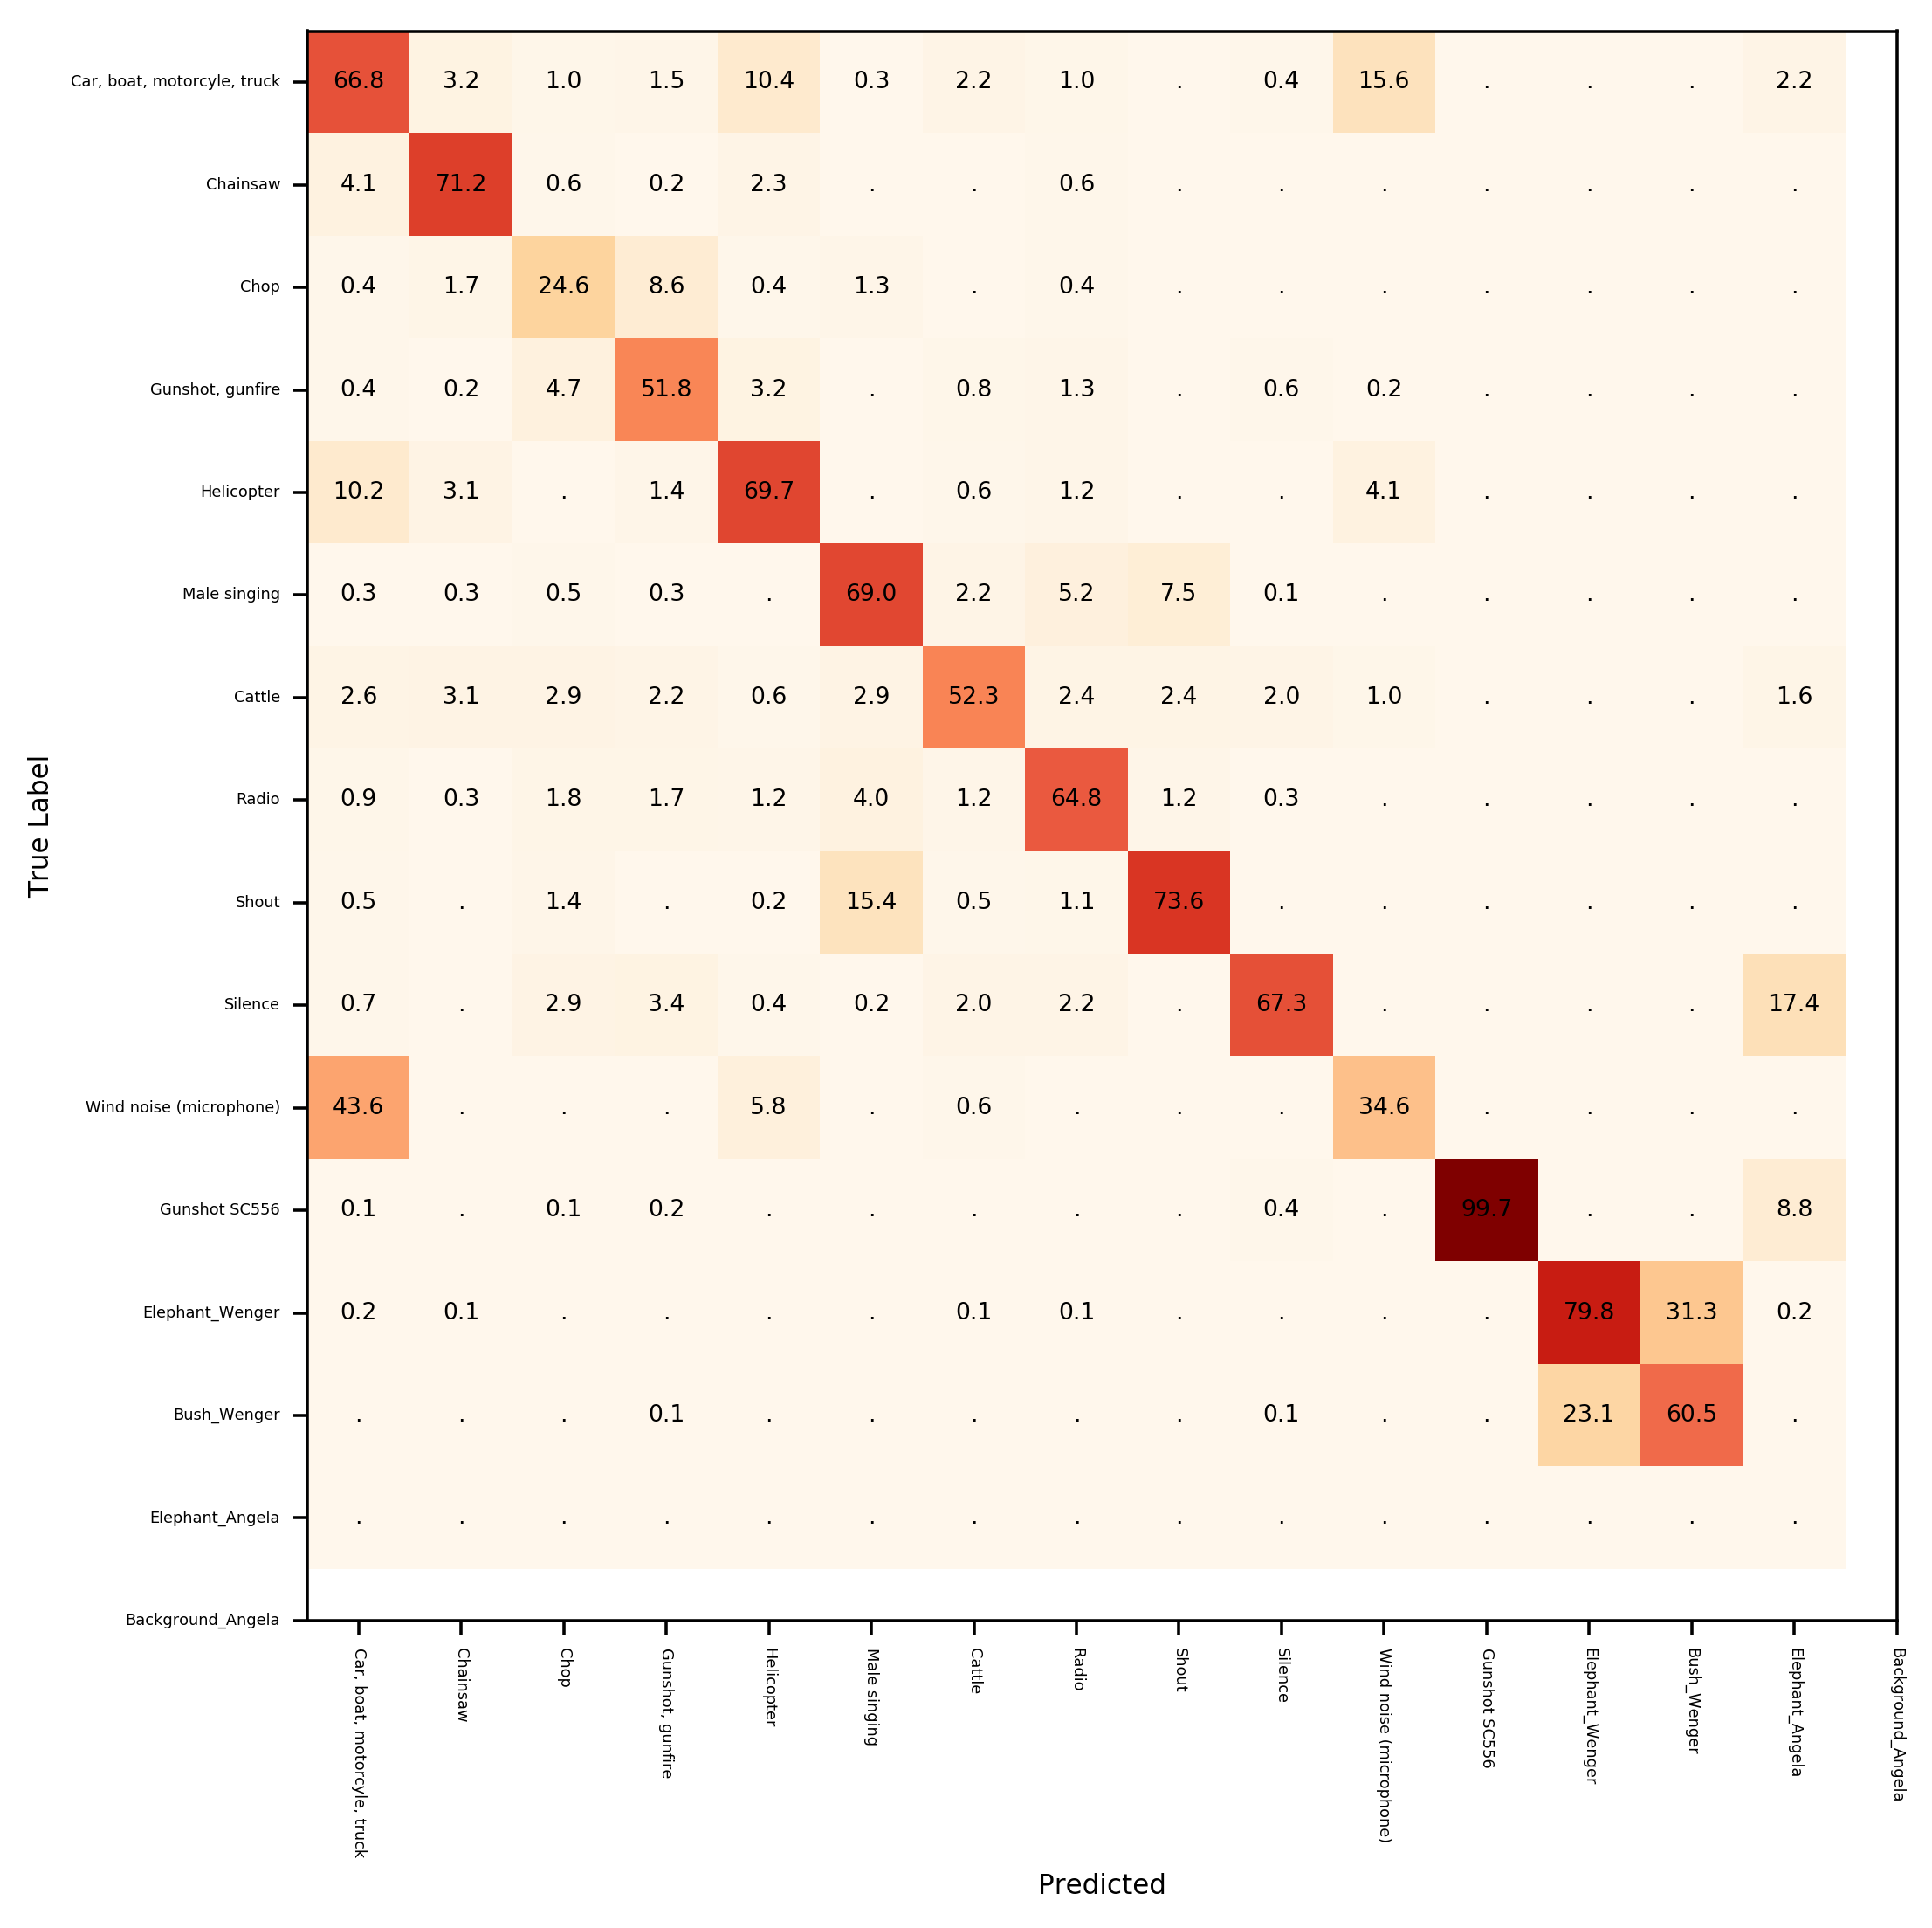

In [91]:
normalize = False

if normalize:
    cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm, copy=True)
    cm = cm.astype('int')

np.set_printoptions(precision=3)
###fig, ax = matplotlib.figure.Figure()

#fig = matplotlib.figure.Figure(figsize=(7, 7), dpi=320, facecolor='w', edgecolor='k')
fig = plt.figure(figsize=(7, 7), dpi=320)

ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(cm, cmap='OrRd')

classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in gt_labels]
classes = ['\n'.join(wrap(l, 40)) for l in classes]

tick_marks = np.arange(len(classes))

ax.set_xlabel('Predicted', fontsize=7)
ax.set_xticks(tick_marks)
c = ax.set_xticklabels(classes, fontsize=4, rotation=-90,  ha='center')
ax.xaxis.set_label_position('bottom')
ax.xaxis.tick_bottom()

ax.set_ylabel('True Label', fontsize=7)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes, fontsize=4, va ='center')
ax.yaxis.set_label_position('left')
ax.yaxis.tick_left()

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, str(round(cm[i, j],1)) if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")
fig.set_tight_layout(True)

In [22]:
score = pd.read_csv(score_filename, sep=";")
score = score.sort_values(by=['aps'], ascending=False)

In [23]:
score

,label,aps
12,Elephant_Wenger,0.993796
1,Chainsaw,0.884480
5,Male singing,0.835291
7,Radio,0.834352
8,Shout,0.818116
4,Helicopter,0.804897
14,Elephant_Angela,0.775979
0,"Car, boat, motorcyle, truck",0.764451
13,Bush_Wenger,0.760058
3,"Gunshot, gunfire",0.751317


In [28]:
abc = pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])

'tfrecords/eval_jungle_new/*.tfrecord'